In [41]:
import standard_metrics
import torch
import torch.nn.functional as F

import numpy as np

In [42]:
# load the dictionaries and sort for ones with similar l1 value

layers = [0, 1, 2, 3, 4, 5]
ratio = 4

device = "cuda:3"

dicts = [(layer, ratio, torch.load(f"/mnt/ssd-cluster/bigrun0308/tied_residual_l{layer}_r{ratio}/_9/learned_dicts.pt")) for layer in layers]

In [43]:
target_l1 = 8e-4

filtered_dicts = {}
for (layer, _, dicts_) in dicts:
    closest_dict = None
    closest_l1 = float("inf")

    for (dict, hyperparams) in dicts_:
        l1_dist = (hyperparams["l1_alpha"] - target_l1) ** 2
        if l1_dist < closest_l1:
            closest_dict = (dict, hyperparams)
            closest_l1 = l1_dist

    filtered_dicts[layer] = closest_dict
    closest_dict[0].to_device(device)

In [44]:
n_features = ratio * 512

covariances = {(i,j): torch.zeros(n_features, n_features, device=device) for i in layers for j in layers if i < j}

print(list(covariances.keys()))

means = {i: torch.zeros(n_features, device=device) for i in range(len(layers))}
variances = {i: torch.zeros(n_features, device=device) for i in range(len(layers))}

datasets = {layer: torch.load(f"activation_data/layer_{layer}/0.pt").to("cpu") for layer in layers}
for _, d in datasets.items():
    d.pin_memory()

dataset_len = datasets[0].shape[0]
batch_size = 2048
n_batches = dataset_len // batch_size

import itertools
import tqdm

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [49]:
torch.autograd.set_grad_enabled(False)

for batch_n in tqdm.tqdm(range(n_batches)):
    samples = {l: datasets[l][batch_size*batch_n:batch_size*(batch_n+1)].to(device, dtype=torch.float32) for l in layers}
    encoded = {l: filtered_dicts[l][0].encode(samples[l]) for l in layers}

    for l in layers:
        means[l] *= batch_n / (batch_n + 1)
        means[l] += torch.mean(encoded[l], dim=0) / (batch_n + 1)

        variances[l] *= batch_n / (batch_n + 1)
        variances[l] += (encoded[l] - means[l]).pow(2).mean(dim=0) / (batch_n + 1)
    
    for (i, j) in covariances.keys():
        covariances[(i, j)] *= batch_n / (batch_n + 1)
        covariances[(i, j)] += (torch.einsum("bi,bj->ij", encoded[i] - means[i], encoded[j] - means[j]) / batch_size) / (n_batches + 1)
    
    del samples, encoded

correlations = {}

for (i, j) in covariances.keys():
    covariances[(i, j)] /= n_batches

    correlations[(i, j)] = covariances[(i, j)] / torch.clamp(torch.sqrt(variances[i] * variances[j]), 1e-8)

torch.save(means, "means_8e-4.pkl")
torch.save(variances, "variances_8e-4.pkl")
torch.save(covariances, "covariances_8e-4.pkl")
torch.save(correlations, "correlations_8e-4.pkl")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:31<00:00, 32.79it/s]


In [68]:
def cosine_sim(model, ground):
    return torch.einsum("md,gd->mg", model.get_learned_dict(), ground.get_learned_dict())

def max_cosine_sim(model, ground):
    csim_max, csim_max_idxs = cosine_sim(model, ground).max(dim=1)
    return csim_max, csim_max_idxs

cs_scores = {(i, j): cosine_sim(filtered_dicts[i][0], filtered_dicts[j][0]) for (i, j) in covariances.keys()}

In [51]:
# linear correlation between cosine sim and covariance

from sklearn.linear_model import LinearRegression
import numpy as np

def linear_correlation(x, y):
    x = np.array(x.cpu()).reshape(-1, 1)
    y = np.array(y.cpu()).reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    return reg.score(x, y)

correlation_r_sq = np.zeros((max(layers)+1, max(layers)+1))

for (i, j) in covariances.keys():
    correlation_r_sq[i, j] = linear_correlation(correlations[i, j], cs_scores[i, j])

tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')
tensor(False, device='cuda:3')


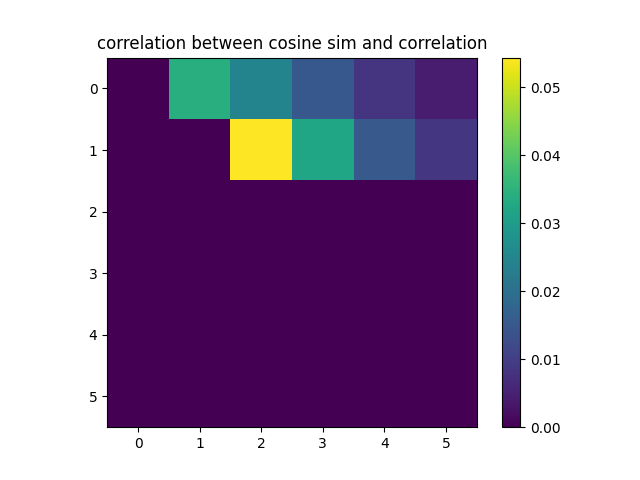

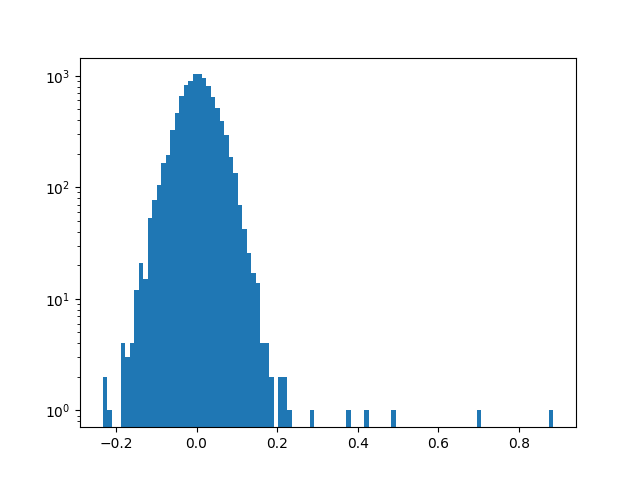

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
c = ax.imshow(correlation_r_sq, cmap="viridis")
ax.set_title("correlation between cosine sim and correlation")
fig.colorbar(c)
plt.savefig("correlation_r_sq.png")

plt.close(fig)

from IPython.display import Image, display
display(Image("correlation_r_sq.png"))

idxs = np.random.choice(covariances[(0, 1)].flatten().shape[0], size=10000, replace=False)

fig, ax = plt.subplots()
ax.hist(cs_scores[(0, 1)].flatten()[idxs].cpu(), bins=100)
ax.set_yscale("log")
plt.savefig("correlation_hist.png")
plt.close(fig)

display(Image("correlation_hist.png"))

In [70]:
layer_0 = 0
layer_1 = 1

cs_max, cs_max_idxs = max_cosine_sim(filtered_dicts[layer_0][0], filtered_dicts[layer_1][0])

fig, ax = plt.subplots()
ax.hist(cs_max.cpu(), bins=100)
ax.set_xlabel("Max Cosine Similarity")
ax.set_ylabel("Count")
plt.savefig("graphs/max_cosine_sim.png")

plt.close(fig)

display(Image("graphs/max_cosine_sim.png"))

TypeError: can't convert cuda:3 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.